In [143]:
import numpy as np
import tensorflow as tf
from curriculum_learning.models.classifier_model import ClassifierModel
from curriculum_learning import utils
import yaml
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [134]:
with open("models_hyperparameters.yaml", "r") as stream:
    models_hyperparameters = yaml.safe_load(stream)
    
with open("config_tests.yaml", "r") as stream:
    config_tests = yaml.safe_load(stream)
    
N_EPOCHS = 50
N_TRIALS = 30
BATCH_SIZE = 512

CONFIG = config_tests["proba_best"]

loss = tf.keras.losses.SparseCategoricalCrossentropy()

In [135]:
ds_1 = tfds.load("stl10", split="train", as_supervised=True, shuffle_files=False)
ds_2 = tfds.load("stl10", split="test", as_supervised=True, shuffle_files=False)

x = []
y = []

for x_, y_ in ds_1.as_numpy_iterator():
    x.append(x_)
    y.append(y_)
    
for x_, y_ in ds_2.as_numpy_iterator():
    x.append(x_)
    y.append(y_)

2024-06-09 17:48:12.126536: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 17:48:12.862043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [136]:
x = np.array(x, dtype=np.float32) / 255
y = np.array(y, dtype=np.float32)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

n_classes = len(np.unique(y))
train_size = x_train.shape[0]
train_size, len(x_val), len(x_test)

(9100, 1950, 1950)

In [161]:
x_train_sorted = x_train[np.argsort(y_train)]
y_train_sorted = y_train[np.argsort(y_train)]

In [162]:
x_edges = []
x_vis = []
for x_, y_ in zip(x_train_sorted, y_train_sorted):
    x_vis.append(x_)
    x_edges.append(utils.sobel_edge_detector(x_ * 255, blur=True))

x_edges = np.array(x_edges) / 255
x_vis = (np.array(x_vis) * 255).astype(int)

In [163]:
edges_sum = np.sum(x_edges, axis=-1)
edges_sum = np.sum(edges_sum, axis=-1)
edges_sum = np.sum(edges_sum, axis=-1)
df_edges_sum = pd.DataFrame(edges_sum, columns=["a"]) / np.sum(edges_sum)

In [189]:
def normalize_losses_per_group(losses, groups_counts):
    normalized_losses = []
    i = 0

    for count in groups_counts:
        la_batch = losses[i: i + count]
        normalized_loss = - (la_batch - np.mean(la_batch)) / np.std(la_batch)
        normalized_loss = np.exp(normalized_loss) / sum(np.exp(normalized_loss))

        normalized_losses.extend(normalized_loss)
        i += count

    return np.array(normalized_losses) / len(groups_counts)

df_edges_sum_2 = pd.DataFrame(normalize_losses_per_group(edges_sum, [910] * 10), columns=["a"])

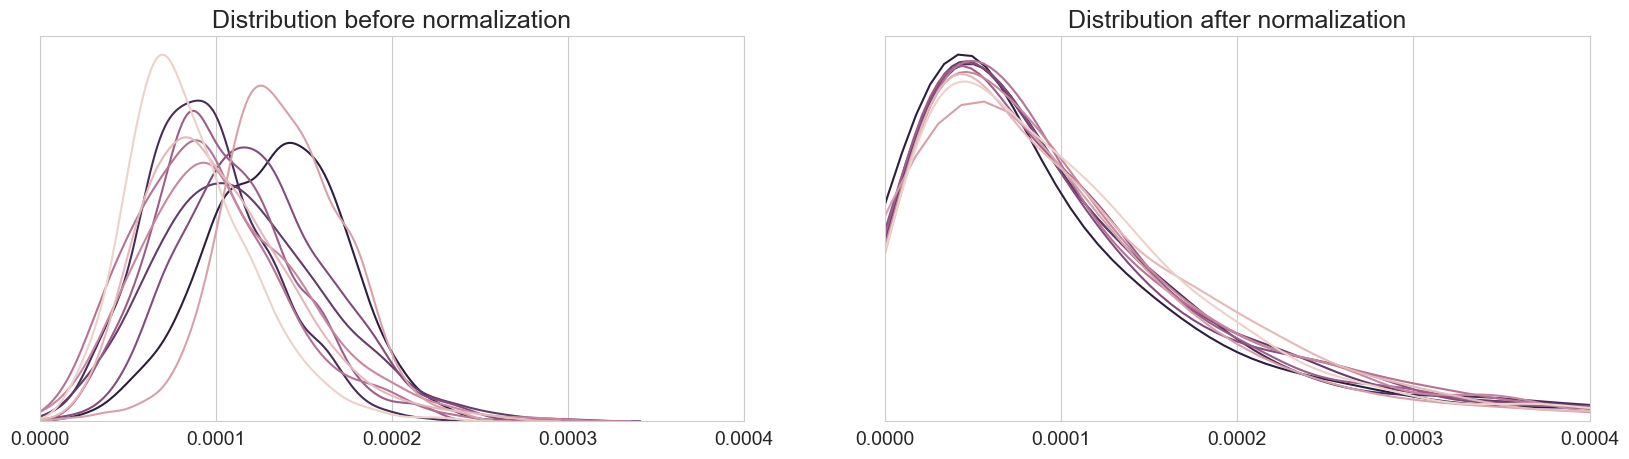

In [245]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
sns.kdeplot(data=df_edges_sum, x="a", hue=y_train_sorted, legend="")
plt.title("Distribution before normalization", fontsize=18)
plt.xlabel("")
plt.ylabel("")
plt.yticks([], [])
plt.xticks([0.0001 * i for i in range(5)], fontsize=14)
plt.xlim([0, 0.0004])

plt.subplot(1, 2, 2)
sns.kdeplot(data=df_edges_sum_2, x="a", hue=y_train_sorted, legend="")
plt.title("Distribution after normalization", fontsize=18)
plt.xlabel("")
plt.ylabel("")
plt.yticks([], [])
plt.xlim([0, 0.0004])
plt.xticks([0.0001 * i for i in range(5)], fontsize=14)
plt.show()

In [239]:
[0.00001 * i for i in range(9)]

[0.0,
 1e-05,
 2e-05,
 3.0000000000000004e-05,
 4e-05,
 5e-05,
 6.000000000000001e-05,
 7.000000000000001e-05,
 8e-05]

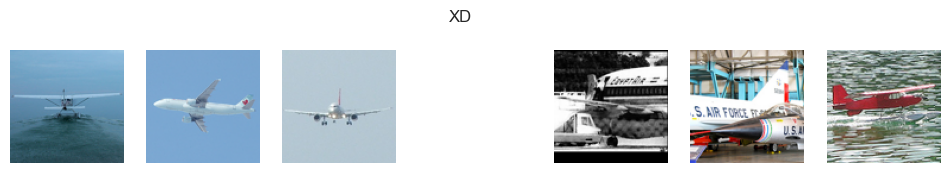

In [98]:
plt.figure(figsize=(12, 2))
plt.suptitle("XD")
for i in range(3):
    j = np.argsort(edges_sum)[i]
    plt.subplot(1, 7, i + 1)
    plt.imshow(x_vis[j])
    plt.axis("off")

for i in range(3):
    j = np.argsort(edges_sum)[-3:][i]
    plt.subplot(1, 7, i + 5)
    plt.imshow(x_vis[j])
    plt.axis("off")

plt.show()

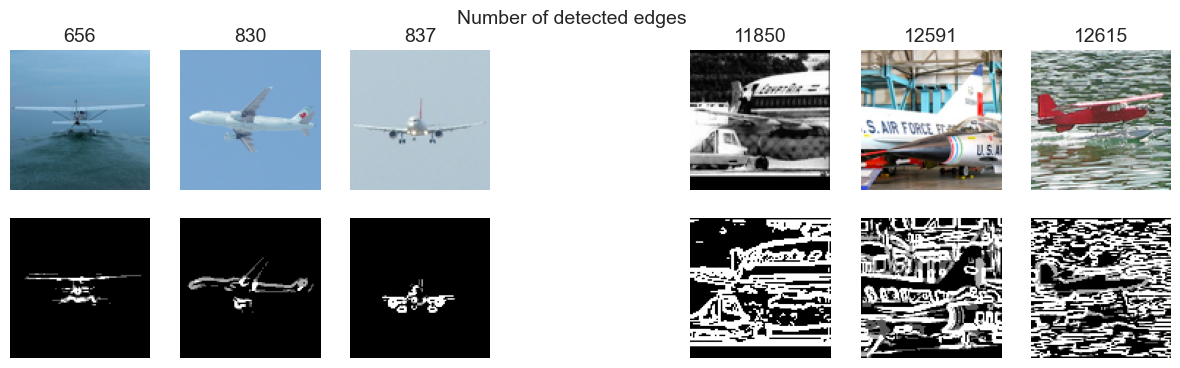

In [127]:
plt.figure(figsize=(15, 4))

fs = 14

plt.suptitle("Number of detected edges", fontsize=fs)


for i in range(3):
    j = np.argsort(edges_sum)[i]
    plt.subplot(2, 7, i + 1)
    plt.imshow(x_vis[j])
    plt.axis("off")
    plt.title(f"{edges_sum[j]:.0f}", fontsize=fs)

for i in range(3):
    j = np.argsort(edges_sum)[-3:][i]
    plt.subplot(2, 7, i + 5)
    plt.imshow(x_vis[j])
    plt.axis("off")
    plt.title(f"{edges_sum[j]:.0f}", fontsize=fs)


for i in range(3):
    j = np.argsort(edges_sum)[i]
    plt.subplot(2, 7, 7 + i + 1)
    plt.imshow(np.mean(x_edges[j], axis=2), cmap='gray')
    plt.axis("off")


for i in range(3):
    j = np.argsort(edges_sum)[-3:][i]
    plt.subplot(2, 7, 7 + i + 5)
    plt.imshow(np.mean(x_edges[j], axis=2), cmap='gray')
    plt.axis("off") 
plt.show()

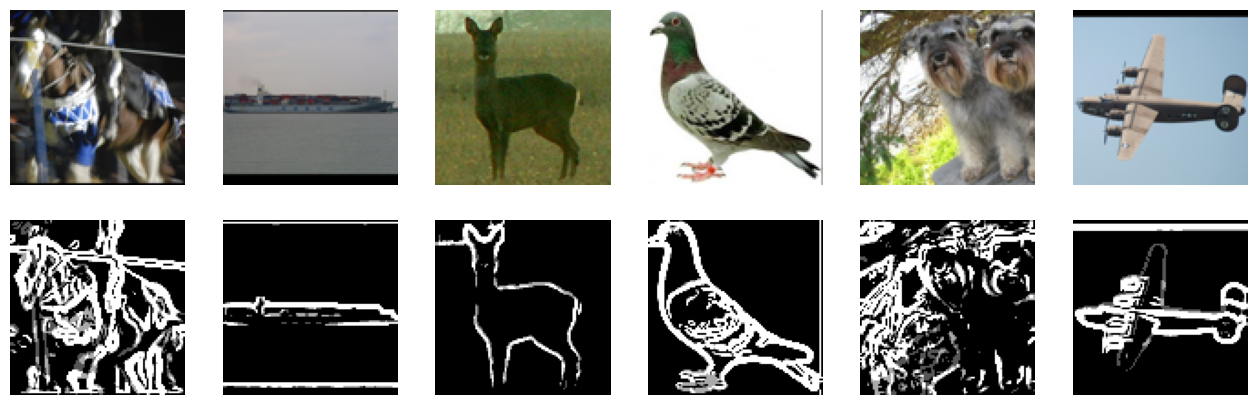

In [132]:
plt.figure(figsize=(16, 5))
for i in range(6):
    j = np.random.randint(0, len(x_train))
    plt.subplot(2, 6, i + 1)
    plt.imshow(x_train[j])
    plt.axis("off")
    plt.subplot(2, 6, i + 7)
    plt.imshow(np.mean(x_edges[j], axis=2), cmap='gray')
    plt.axis("off")
plt.show()

In [6]:
ds_2 = tfds.load("stl10", split="test", as_supervised=True, shuffle_files=False)
for x_, y_ in ds_2.as_numpy_iterator():
    x.append(x_)
    y.append(y_)

2024-06-04 18:42:37.635127: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [38]:
x = np.array(x, dtype=np.float32) / 255
y = np.array(y, dtype=np.float32)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

n_classes = len(np.unique(y))
train_size = x_train.shape[0]
train_size, len(x_val), len(x_test)

(18900, 4050, 4050)

In [39]:
9100 + 1950 + 1950

13000

In [6]:
x_train_sorted = x_train[np.argsort(y_train)]
y_train_sorted = y_train[np.argsort(y_train)]
_, counts = np.unique(y_train_sorted, return_counts=True)

In [7]:
model = ClassifierModel(output_shape=n_classes, **models_hyperparameters["test_model_1"])
model.compile(optimizer="adam", loss=loss, metrics=["accuracy"])
model(x_train[0:1])
# model.save_weights("../models/default_model.weights.h5")
model.load_weights("../models/default_model.weights.h5")
model_weights = model.get_weights()

In [8]:
CONFIG

{'order_type': 'proba'}

In [14]:
model_scores = []
verbose = 0
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=5, start_from_epoch=0)

for _ in tqdm(range(N_TRIALS)):
    model.set_weights(model_weights)

    for i in range(N_EPOCHS):
        n_samples = int(np.tanh(4 * (i + 1) / N_EPOCHS) * train_size)

        samples_proba = utils.calculate_proba(
            model, x_train_sorted, y_train_sorted, counts, batch_size=BATCH_SIZE
        )

        samples_ids = utils.chose_samples(n_samples, samples_proba, CONFIG["order_type"])

        model.fit(
            x_train_sorted[samples_ids],
            y_train_sorted[samples_ids],
            # validation_data=(x_val, y_val),
            epochs=1,
            batch_size=BATCH_SIZE,
            verbose=verbose,
        )

    model.fit(
        x_train, y_train, validation_data=(x_val, y_val), epochs=500, batch_size=BATCH_SIZE, 
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=5, start_from_epoch=10)], 
        verbose=verbose
    )
            
    _, accuracy = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE, verbose=1)
    model_scores.append(accuracy)
    print("Mean:", np.mean(model_scores), " Median: ", np.median(model_scores))

  0%|          | 0/30 [00:00<?, ?it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8317 - loss: 0.5113


  3%|▎         | 1/30 [02:04<1:00:14, 124.63s/it]

Mean: 0.8392592668533325  Median:  0.8392592668533325
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8100 - loss: 0.6265


  7%|▋         | 2/30 [04:12<59:05, 126.62s/it]  

Mean: 0.8249382674694061  Median:  0.8249382674694061
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8490 - loss: 0.5146


 10%|█         | 3/30 [06:33<59:58, 133.28s/it]

Mean: 0.8339094718297323  Median:  0.8392592668533325
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8094 - loss: 0.6249


 13%|█▎        | 4/30 [08:46<57:37, 132.97s/it]

Mean: 0.8283950686454773  Median:  0.8255555629730225
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8663 - loss: 0.4237


 17%|█▋        | 5/30 [11:11<57:12, 137.30s/it]

Mean: 0.8352592706680297  Median:  0.8392592668533325
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7870 - loss: 0.6602


 20%|██        | 6/30 [13:26<54:39, 136.65s/it]

Mean: 0.8274897237618765  Median:  0.8255555629730225
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8273 - loss: 0.5355


 23%|██▎       | 7/30 [15:39<51:53, 135.37s/it]

Mean: 0.8276896050998143  Median:  0.8288888931274414
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8237 - loss: 0.5625


 27%|██▋       | 8/30 [17:51<49:12, 134.19s/it]

Mean: 0.8274074196815491  Median:  0.827160507440567
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8200 - loss: 0.5770


 30%|███       | 9/30 [20:02<46:37, 133.23s/it]

Mean: 0.8270507653554281  Median:  0.8254321217536926
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8352 - loss: 0.5051


 33%|███▎      | 10/30 [22:16<44:29, 133.49s/it]

Mean: 0.8283703804016114  Median:  0.827160507440567
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7819 - loss: 0.7434


 37%|███▋      | 11/30 [24:20<41:24, 130.78s/it]

Mean: 0.8244893442500721  Median:  0.8254321217536926
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8076 - loss: 0.6499


 40%|████      | 12/30 [26:30<39:07, 130.41s/it]

Mean: 0.823148156205813  Median:  0.8248148262500763
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8280 - loss: 0.5333


 43%|████▎     | 13/30 [28:40<36:52, 130.14s/it]

Mean: 0.8238176703453064  Median:  0.8254321217536926
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7984 - loss: 0.6512


 47%|████▋     | 14/30 [30:49<34:39, 129.95s/it]

Mean: 0.8225396871566772  Median:  0.8248148262500763
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8174 - loss: 0.5564


 50%|█████     | 15/30 [33:06<33:00, 132.06s/it]

Mean: 0.8224032958348592  Median:  0.82419753074646
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8263 - loss: 0.5450


 53%|█████▎    | 16/30 [35:17<30:44, 131.73s/it]

Mean: 0.8227777816355228  Median:  0.8248148262500763
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7174 - loss: 1.1917


 57%|█████▋    | 17/30 [37:25<28:19, 130.74s/it]

Mean: 0.8168046509518343  Median:  0.82419753074646
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7627 - loss: 0.7707


 60%|██████    | 18/30 [39:32<25:55, 129.65s/it]

Mean: 0.8136762711736891  Median:  0.8223456740379333
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8010 - loss: 0.5952


 63%|██████▎   | 19/30 [41:41<23:43, 129.42s/it]

Mean: 0.8130214433921011  Median:  0.8204938173294067
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7802 - loss: 0.7341


 67%|██████▋   | 20/30 [43:50<21:32, 129.29s/it]

Mean: 0.8113086432218551  Median:  0.8161728382110596
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8524 - loss: 0.4515


 70%|███████   | 21/30 [46:00<19:24, 129.37s/it]

Mean: 0.8133803662799653  Median:  0.8204938173294067
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8015 - loss: 0.6867


 73%|███████▎  | 22/30 [48:12<17:22, 130.30s/it]

Mean: 0.8129405189644207  Median:  0.8161728382110596
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8412 - loss: 0.5303


 77%|███████▋  | 23/30 [50:23<15:12, 130.41s/it]

Mean: 0.8142243727393772  Median:  0.8204938173294067
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7691 - loss: 0.8240


 80%|████████  | 24/30 [52:36<13:07, 131.22s/it]

Mean: 0.8123868356148402  Median:  0.8161728382110596
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8343 - loss: 0.5145


 83%|████████▎ | 25/30 [54:58<11:11, 134.28s/it]

Mean: 0.8134617328643798  Median:  0.8204938173294067
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7822 - loss: 0.7724


 87%|████████▋ | 26/30 [57:06<08:50, 132.63s/it]

Mean: 0.8124311543427981  Median:  0.8161728382110596
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7980 - loss: 0.6383


 90%|█████████ | 27/30 [59:23<06:41, 133.84s/it]

Mean: 0.8119341620692501  Median:  0.8118518590927124
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8283 - loss: 0.5468


 93%|█████████▎| 28/30 [1:01:38<04:28, 134.03s/it]

Mean: 0.8126014173030853  Median:  0.8161728382110596
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8387 - loss: 0.5375


 97%|█████████▋| 29/30 [1:03:54<02:14, 134.70s/it]

Mean: 0.8135632235428383  Median:  0.8204938173294067
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8420 - loss: 0.5117


100%|██████████| 30/30 [1:06:18<00:00, 132.61s/it]

Mean: 0.8145761370658875  Median:  0.8223456740379333


In [15]:
np.min(model_scores)

0.7212345600128174

In [11]:
print("Mean:", np.mean(model_scores), " Median: ", np.median(model_scores))

Mean: 0.6160512844721476  Median:  0.6143589615821838


In [18]:
print("Mean:", np.mean(model_scores), " Median: ", np.median(model_scores))

Mean: 0.5817307829856873  Median:  0.5800000131130219


In [17]:
CONFIG

{'order_type': 'proba'}

In [16]:
model_scores

[0.8392592668533325,
 0.8106172680854797,
 0.8518518805503845,
 0.8118518590927124,
 0.8627160787582397,
 0.7886419892311096,
 0.8288888931274414,
 0.8254321217536926,
 0.82419753074646,
 0.8402469158172607,
 0.7856789827346802,
 0.8083950877189636,
 0.8318518400192261,
 0.8059259057044983,
 0.8204938173294067,
 0.8283950686454773,
 0.7212345600128174,
 0.760493814945221,
 0.8012345433235168,
 0.7787654399871826,
 0.8548148274421692,
 0.8037037253379822,
 0.8424691557884216,
 0.7701234817504883,
 0.8392592668533325,
 0.7866666913032532,
 0.7990123629570007,
 0.8306173086166382,
 0.8404937982559204,
 0.843950629234314]

In [17]:
CONFIG

{'order_type': 'fixed'}

In [26]:
model_scores_random = []
verbose = 0

for _ in tqdm(range(N_TRIALS)):
    model.set_weights(model_weights)

    model.fit(
        x_train, y_train, validation_data=(x_val, y_val), epochs=500, batch_size=BATCH_SIZE, verbose=verbose, shuffle=True, 
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=5, start_from_epoch=35)]
    )

    _, accuracy = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE, verbose=1)
    model_scores_random.append(accuracy)
    print("Mean:", np.mean(model_scores_random), " Median: ", np.median(model_scores_random))

  0%|          | 0/30 [00:00<?, ?it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8059 - loss: 0.5594


  3%|▎         | 1/30 [00:48<23:24, 48.45s/it]

Mean: 0.8125925660133362  Median:  0.8125925660133362
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8031 - loss: 0.6061


  7%|▋         | 2/30 [01:35<22:12, 47.58s/it]

Mean: 0.8083950579166412  Median:  0.8083950579166412
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8198 - loss: 0.5565


 10%|█         | 3/30 [02:23<21:36, 48.03s/it]

Mean: 0.812674899895986  Median:  0.8125925660133362
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8284 - loss: 0.5527


 13%|█▎        | 4/30 [03:28<23:41, 54.68s/it]

Mean: 0.8162345737218857  Median:  0.8169135749340057
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7697 - loss: 0.7453


 17%|█▋        | 5/30 [04:21<22:29, 53.99s/it]

Mean: 0.8078518509864807  Median:  0.8125925660133362
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7853 - loss: 0.7086


 20%|██        | 6/30 [05:12<21:10, 52.95s/it]

Mean: 0.8043209910392761  Median:  0.8083950579166412
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7983 - loss: 0.6246


 23%|██▎       | 7/30 [06:06<20:23, 53.20s/it]

Mean: 0.8034215228898185  Median:  0.8041975498199463
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7125 - loss: 1.1023


 27%|██▋       | 8/30 [06:53<18:47, 51.23s/it]

Mean: 0.7918209955096245  Median:  0.8011111319065094
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8023 - loss: 0.6186


 30%|███       | 9/30 [07:44<17:58, 51.37s/it]

Mean: 0.7934705151451958  Median:  0.8041975498199463
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7411 - loss: 0.8934


 33%|███▎      | 10/30 [08:29<16:27, 49.36s/it]

Mean: 0.7884444534778595  Median:  0.8011111319065094
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8534 - loss: 0.4450


 37%|███▋      | 11/30 [09:17<15:28, 48.87s/it]

Mean: 0.7943209951574152  Median:  0.8041975498199463
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7839 - loss: 0.6460


 40%|████      | 12/30 [10:05<14:32, 48.50s/it]

Mean: 0.7940535048643748  Median:  0.8011111319065094
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8221 - loss: 0.5808


 43%|████▎     | 13/30 [10:58<14:07, 49.88s/it]

Mean: 0.7961443570943979  Median:  0.8041975498199463
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7682 - loss: 0.7262


 47%|████▋     | 14/30 [11:45<13:07, 49.19s/it]

Mean: 0.7942328112465995  Median:  0.8011111319065094
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7069 - loss: 0.9492


 50%|█████     | 15/30 [12:31<12:03, 48.20s/it]

Mean: 0.7888230522473653  Median:  0.7980247139930725
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7683 - loss: 0.8123


 53%|█████▎    | 16/30 [13:17<11:03, 47.39s/it]

Mean: 0.7875463031232357  Median:  0.7945679128170013
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8406 - loss: 0.5030


 57%|█████▋    | 17/30 [14:12<10:47, 49.79s/it]

Mean: 0.7906172906651217  Median:  0.7980247139930725
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7999 - loss: 0.6323


 60%|██████    | 18/30 [14:59<09:45, 48.77s/it]

Mean: 0.7910013794898987  Median:  0.7977778017520905
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8221 - loss: 0.5673


 63%|██████▎   | 19/30 [15:56<09:24, 51.32s/it]

Mean: 0.7929174868684066  Median:  0.7980247139930725
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7592 - loss: 0.7761


 67%|██████▋   | 20/30 [16:44<08:23, 50.35s/it]

Mean: 0.7913456857204437  Median:  0.7977778017520905
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8494 - loss: 0.4513


 70%|███████   | 21/30 [17:38<07:43, 51.47s/it]

Mean: 0.7941093529973712  Median:  0.7980247139930725
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7179 - loss: 1.0942


 73%|███████▎  | 22/30 [18:23<06:36, 49.57s/it]

Mean: 0.7907856404781342  Median:  0.7977778017520905
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7809 - loss: 0.6461


 77%|███████▋  | 23/30 [19:09<05:40, 48.60s/it]

Mean: 0.7904669953429181  Median:  0.7975308895111084
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8023 - loss: 0.5972


 80%|████████  | 24/30 [20:00<04:55, 49.25s/it]

Mean: 0.7912037099401156  Median:  0.7977778017520905
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8427 - loss: 0.5072


 83%|████████▎ | 25/30 [20:56<04:16, 51.24s/it]

Mean: 0.7933629679679871  Median:  0.7980247139930725
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8221 - loss: 0.5502


 87%|████████▋ | 26/30 [21:46<03:23, 50.97s/it]

Mean: 0.7944349531943982  Median:  0.8011111319065094
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8349 - loss: 0.4723


 90%|█████████ | 27/30 [22:37<02:32, 50.89s/it]

Mean: 0.7959670843901457  Median:  0.8041975498199463
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7099 - loss: 1.2599


 93%|█████████▎| 28/30 [23:22<01:38, 49.09s/it]

Mean: 0.792786602463041  Median:  0.8011111319065094
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7810 - loss: 0.7174


 97%|█████████▋| 29/30 [24:12<00:49, 49.21s/it]

Mean: 0.7925159705096277  Median:  0.7980247139930725
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7862 - loss: 0.6834


100%|██████████| 30/30 [25:06<00:00, 50.23s/it]

Mean: 0.7924938340981801  Median:  0.7977778017520905


In [27]:
model_scores_random

[0.8125925660133362,
 0.8041975498199463,
 0.8212345838546753,
 0.826913595199585,
 0.7743209600448608,
 0.7866666913032532,
 0.7980247139930725,
 0.7106173038482666,
 0.8066666722297668,
 0.7432098984718323,
 0.8530864119529724,
 0.7911111116409302,
 0.8212345838546753,
 0.7693827152252197,
 0.7130864262580872,
 0.7683950662612915,
 0.8397530913352966,
 0.7975308895111084,
 0.8274074196815491,
 0.7614814639091492,
 0.8493826985359192,
 0.7209876775741577,
 0.7834568023681641,
 0.8081481456756592,
 0.8451851606369019,
 0.8212345838546753,
 0.8358024954795837,
 0.7069135904312134,
 0.7849382758140564,
 0.7918518781661987]

In [13]:
np.mean(model_scores), np.mean(model_scores_random)

NameError: name 'model_scores' is not defined

In [16]:
import scipy.stats
scipy.stats.ttest_ind(model_scores, model_scores_random)

TtestResult(statistic=4.752362071023242, pvalue=1.3666137160185319e-05, df=58.0)